# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div><div class="lev1 toc-item"><a href="#Trajector-Clustering-on-Dimension-reduction" data-toc-modified-id="Trajector-Clustering-on-Dimension-reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trajector Clustering on Dimension reduction</a></div><div class="lev2 toc-item"><a href="#using-4-clusters-on-PC1." data-toc-modified-id="using-4-clusters-on-PC1.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>using 4 clusters on PC1.</a></div><div class="lev1 toc-item"><a href="#Trajectory-Clustering-by-Weight" data-toc-modified-id="Trajectory-Clustering-by-Weight-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trajectory Clustering by Weight</a></div>

# reading and preparing data

In [117]:
#library(ggbiplot)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [118]:
dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, WTKG.estimate) %>%
    filter(complete.cases(.)) %>% group_by(SUBJID) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
    filter(measurementId < 7) %>%
    filter(tot_measurements >1) %>% 
    ungroup %>%
     filter(GAGEDAYS > 100, GAGEDAYS <310)

dat.train = dat.train.raw %>% dplyr::select(-WTKG.estimate)
dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,WTKG.estimate,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1.7124993,1,4
224,1003,25.6,29.2,8.2,6.3,1.7124993,2,4
263,1003,30.2,31.0,9.1,7.2,2.6278574,3,4
266,1003,30.2,31.0,9.1,7.2,2.6278574,4,4
169,1005,18.7,21.9,5.9,4.1,0.5989562,1,3
222,1005,25.7,27.9,7.9,5.5,1.4557182,2,3


# Trajector Clustering on Dimension reduction

We use PCA to reduce the four physical variables to one single dimension

In [119]:
#dat.train %>% head

dat.prcomp = dat.train  %>%
    select(-GAGEDAYS, -SUBJID, -measurementId, -tot_measurements) %>% 
    filter(complete.cases(.)) %>% 
    mutate_each(funs(as.numeric(.))) %>%
    prcomp(., center=T, scale.=T)

dat.train  %>%
    select(-GAGEDAYS, -SUBJID, -measurementId, -tot_measurements) %>% 
    filter(complete.cases(.)) %>% 
    head
dat.prcomp$x %>% head

dat.train %>% nrow

ABCIRCM,HCIRCM,BPDCM,FEMURCM
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2
30.2,31.0,9.1,7.2
18.7,21.9,5.9,4.1
25.7,27.9,7.9,5.5


PC1,PC2,PC3,PC4
-0.7259952,0.19000650,-0.2912082,0.01129281
-0.7259952,0.19000650,-0.2912082,0.01129281
-1.9086354,-0.02391508,-0.2858182,-0.20697391
-1.9086354,-0.02391508,-0.2858182,-0.20697391
2.1286479,0.06515534,0.1024382,0.08093121
-0.2038839,0.20896379,0.1604442,-0.01146474


[1] 7164

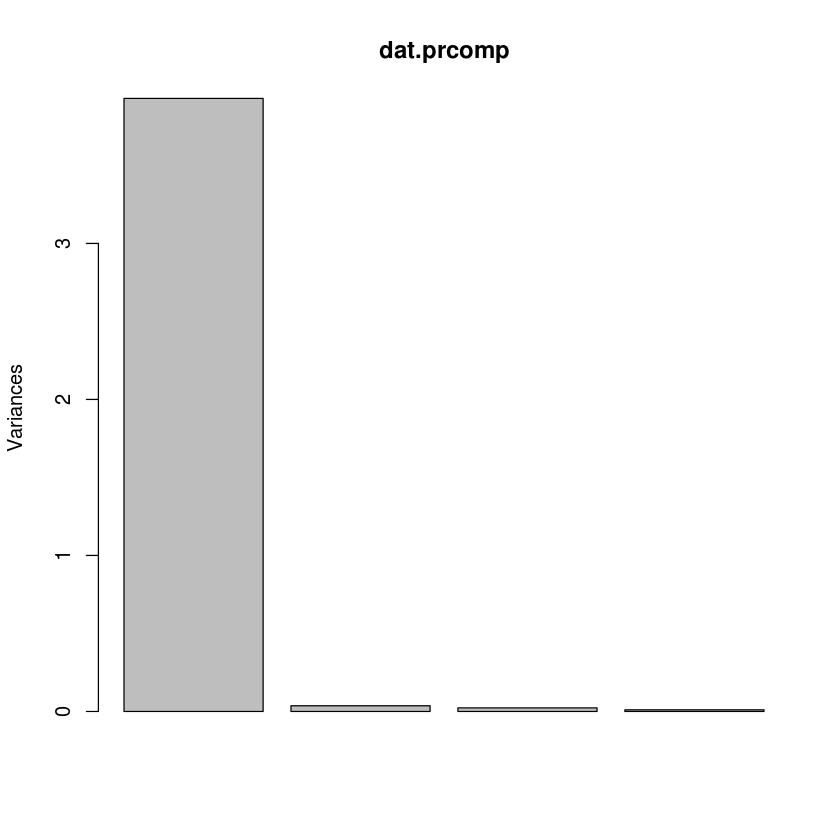

In [120]:
plot(dat.prcomp)

In [ ]:
PC = dat.prcomp$x %>% tbl_df %>% select(PC1, PC2) 

dat.train$PC1 = -1 * PC$PC1
dat.train$PC2 = -1 * PC$PC2
dat.train %>% head



In [122]:
dat.times = dat.train %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train %>% 
    select(SUBJID, measurementId, PC1) %>%  
    spread(measurementId, PC1) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

In [123]:
dat.times %>% head
dat.values %>% head


,SUBJID,1,2,3,4,5,6
1,1003,223,224,263,266,NA,NA
2,1005,169,222,264,NA,NA,NA
3,1006,222,266,NA,NA,NA,NA
4,1009,168,231,NA,NA,NA,NA
5,1011,168,219,261,NA,NA,NA
6,1012,168,169,231,232,259,260


,SUBJID,1,2,3,4,5,6
1,1003,0.7259952,0.7259952,1.908635,1.908635,NA,NA
2,1005,-2.1286479,0.2038839,1.664705,NA,NA,NA
3,1006,0.7414450,1.9884762,NA,NA,NA,NA
4,1009,-2.5661299,0.6405581,NA,NA,NA,NA
5,1011,-2.4107879,-0.1732034,1.323432,NA,NA,NA
6,1012,-2.2493502,-2.2493502,1.039961,1.039961,2.286775,2.286775


In [124]:
library(traj)

In [125]:
s1.pc1 = step1measures(dat.values, dat.times, ID=T)

[1] "Correlation of m1 and m5 : 1"
[1] "Correlation of m11 and m15 : 1"


In [126]:
s2.pc1 = step2factors(s1.pc1)

[1] "m5 is removed because it is perfectly correlated with m1"  
[2] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


In [127]:
s3.pc1 = step3clusters(s2.pc1,4 )
s3.pc1$clusters %>% count(cluster)


cluster,n
1,1
2,12
3,5
4,578


## using 4 clusters on PC1. 

Cluster 4 has a drop between days 150-200

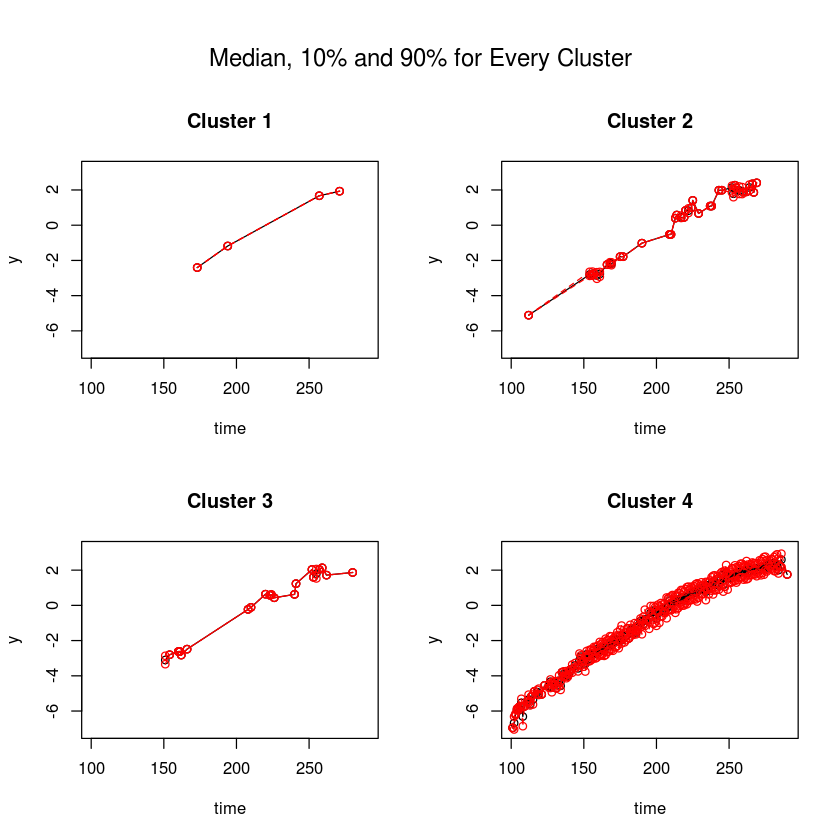

In [128]:
plotMedTraj(s3.pc1)

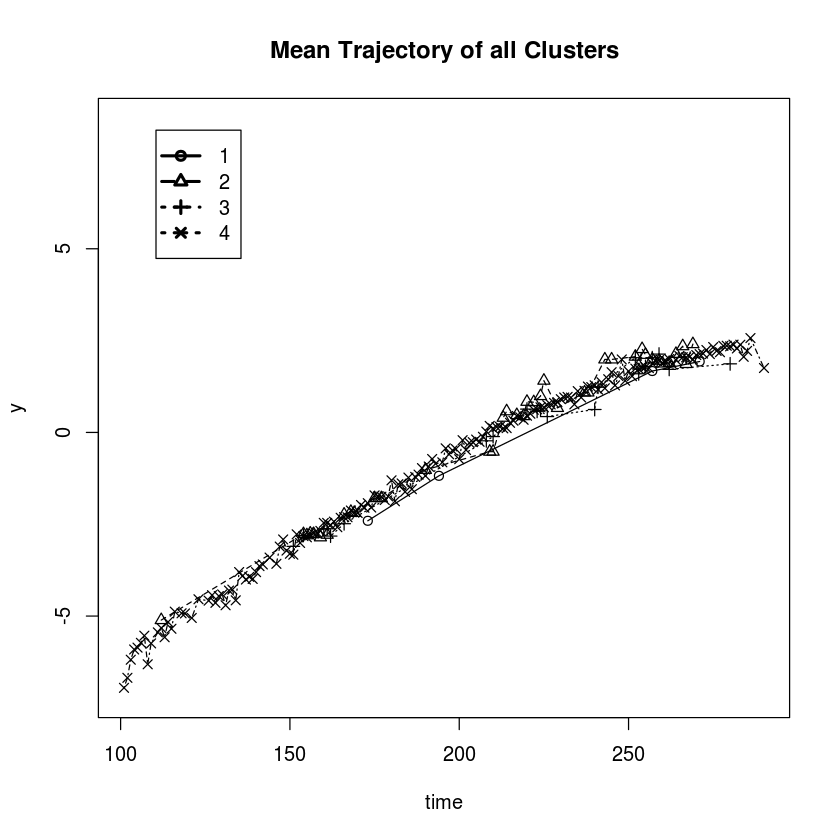

In [129]:
plotCombTraj(s3.pc1)

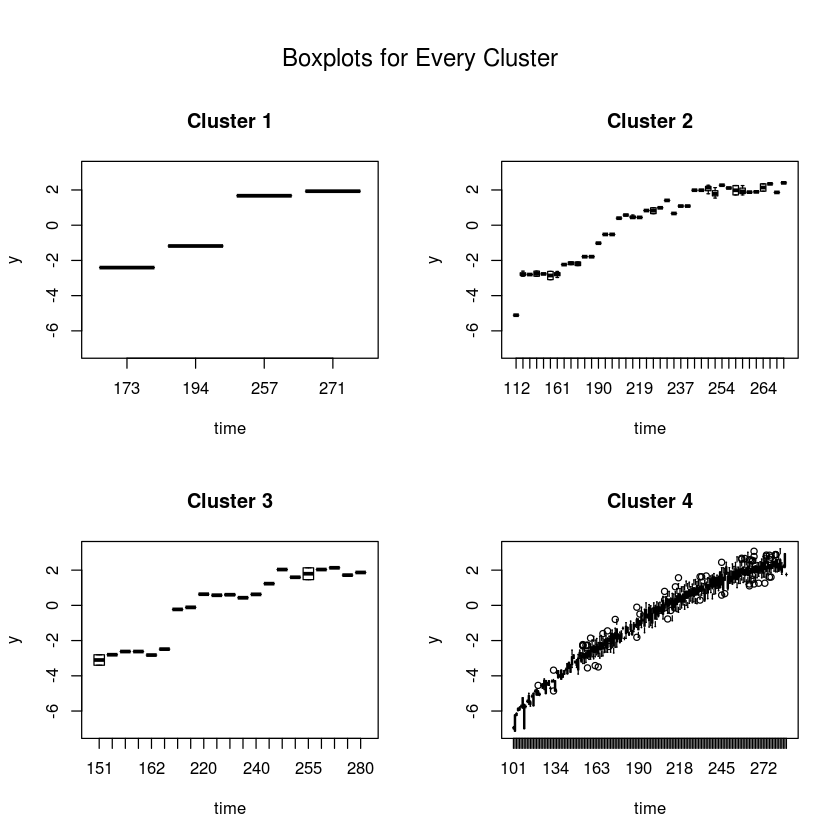

In [130]:
plotBoxplotTraj(s3.pc1)

## Trajectory Clustering on PC1

In [131]:
dat.values.pc2 = dat.train %>% 
    select(SUBJID, measurementId, PC2) %>%  
    spread(measurementId, PC2) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

In [132]:
dat.values.pc2 %>% head

,SUBJID,1,2,3,4,5,6
1,1003,-0.190006503,-0.19000650,0.023915083,0.023915083,NA,NA
2,1005,-0.065155341,-0.20896379,-0.058383617,NA,NA,NA
3,1006,-0.150366558,-0.14903644,NA,NA,NA,NA
4,1009,0.003741555,0.04956008,NA,NA,NA,NA
5,1011,0.207196087,-0.08341447,0.092930794,NA,NA,NA
6,1012,0.188052484,0.18805248,0.003007464,0.003007464,0.2014879,0.2014879


In [133]:
s1.pc2 = step1measures(dat.values.pc2, dat.times, ID=T)


[1] "Correlation of m17 and m18 : 1"


In [134]:
s1.pc2$measurments$m5 = NULL

In [ ]:
s2.pc2 = step2factors(s1.pc2)


In [ ]:
s3.pc2 = step3clusters(s2.pc2, 2)
plotMedTraj(s3.pc2)

# Trajectory Clustering by Weight


In [ ]:
dat.train.raw %>% head


In [ ]:
dat.times = dat.train.raw %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train.raw %>% 
    select(SUBJID, measurementId, WTKG.estimate) %>%  
    spread(measurementId, WTKG.estimate) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

dat.times %>% head
dat.values %>% head

In [ ]:
s1 = step1measures(dat.values, dat.times, ID=T)

In [ ]:
s2 = step2factors(s1)

In [ ]:
s3 = step3clusters(s2)
s3$clusters %>% count(cluster)

In [ ]:
plotMedTraj(s3)

In [ ]:
plotCombTraj(s3)

In [ ]:
s3.2c = step3clusters(s2, 2)
s3.2c$clusters %>% count(cluster)
plotCombTraj(s3.2c)
plotBoxplotTraj(s3.2c)